## 3. Uncertainty Quantification

In [2]:
import warnings
warnings.filterwarnings('ignore')

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from cv2 import resize
from datetime import datetime
from gc import collect
from os import cpu_count
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

sys.path.append(f"{os.getcwd()}/working ViT/")
sys.path.append(f"{os.getcwd()}/mltfm/")
from VisionTransformer_working import VisionTransformer as vit_old

2023-01-12 13:50:31.887051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 13:50:32.097659: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-12 13:50:32.097682: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-12 13:50:32.136157: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-12 13:50:32.708425: W tensorflow/stream_executor/platform/de

In [3]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [4]:
collect()
torch.cuda.empty_cache()
device =torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


### MC Dropout

Load CNN and ViT model.

In [8]:
vit = vit_old(dspl_size=104, 
              patch_size=8, 
              embed_dim=128,
              depth=12,
              n_heads=8,
              mlp_ratio=4.,
              p=0.,
              attn_p=0.,
              drop_path=0.).double()

In [9]:
path_to_pth = 'working ViT/logs_and_weights/ViT-2022-Dec-10 23:18:41/ViT-2022-Dec-10 23:18:41_best_val_loss_2.365828e-06.pth'

In [10]:
if torch.cuda.is_available():
    vit.load_state_dict(torch.load(path_to_pth)['best_model_weights'], strict=True)
else:
    vit.load_state_dict(torch.load(path_to_pth, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

In [7]:
os.getcwd()

'/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM'

In [8]:
cnn = keras.models.load_model('../mltfm/models/model_noise_1e-4.h5')

2023-01-02 14:17:23.016281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 14:17:23.021269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 14:17:23.021667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 14:17:23.022577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2023-01-02 14:17:23.783117: I tensorflow/stream_executor/cuda/cuda_driver.cc:733] failed to allocate 2.2K (2304 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-01-02 14:17:23.783784: I tensorflow/stream_executor/cuda/cuda_driver.cc:733] failed to allocate 2.2K (2304 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-01-02 14:17:23.784445: I tensorflow/stream_executor/cuda/cuda_driver.cc:733] failed to allocate 2.2K (2304 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-01-02 14:17:23.785110: I tensorflow/stream_executor/cuda/cuda_driver.cc:733] failed to allocate 2.2K (2304 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-01-02 14:17:23.785774: I tensorflow/stream_executor/cuda/cuda_driver.cc:733] failed to allocate 2.2K (2304 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-01-02 14:17:23.786450: I tensorflow/stream_executor/cuda/cuda_driver.cc:733] failed to allocate 2.2K (2304 bytes) from device: CUDA_ERR


KeyboardInterrupt



Enable dropout during inference in the CNN.

In [ ]:
config = cnn_weights.get_config()

for i, layer in enumerate(config['layers']):
    if layer['class_name'] == 'Dropout':
        layer['inbound_nodes'][0][0][-1]['training'] = True
        
cnn_ = keras.Model.from_config(config)
cnn_.load_weights('mltfm/models/model_noise_1e-4.h5')

For both the CNN and ViT, compute `n_forward_passes` for each of the 25 test samples. Note that the CNN contains 6 dropout layers (p=0.1) and the ViT contains 12 dropout layers in the MLP module of each encoder block (p=0.1).

In [ ]:
from main_dist import inference_with_dropout

n_forward_passes = 10

predictions_vit = torch.zeros(25, 10, 2, 104, 104)
predictions_cnn = torch.zeros(25, 10, 2, 104, 104)
for i in range(0, len(X_test)):
    for j in range(0, n_forward_passes):
        predictions_vit[i, j, :, :, :] = inference_with_dropout(vit_weights, X_test[i][np.newaxis, ...], return_attn_scores=False)
        predictions_cnn[i, j, :, :, :] = torch.tensor(np.moveaxis(np.array((cnn_(dspl[i][np.newaxis, ...]))), 3, 1))

In [ ]:
Calculate loss per prediction and loss of averaged prediction.

In [ ]:
averaged_pred_vit = 1/n_forward_passes * predictions_vit.sum(dim=1)
averaged_pred_cnn = 1/n_forward_passes * predictions_cnn.sum(dim=1)

losses_vit = torch.zeros(25, 10)
losses_cnn = torch.zeros(25, 10)
for i in range(0, len(X_test)):
    for j in range(0, n_forward_passes):
        losses_vit[i, j] = torch.sum(loss(predictions_vit[i, j], Y_test[i]))
        losses_cnn[i, j] = torch.sum(loss(predictions_cnn[i, j], Y_test[i]))

In [ ]:
loss_mean_per_sample_vit = torch.mean(losses_vit, axis=1)
loss_mean_per_sample_cnn = torch.mean(losses_cnn, axis=1)

In [ ]:
loss_variance_per_sample_vit = torch.var(losses_vit, axis=1)
loss_variance_per_sample_cnn = torch.var(losses_cnn, axis=1)

In [ ]:
avg_test_rmse_vit = torch.mean(loss_mean_per_sample_vit)
avg_test_rmse_cnn = torch.mean(loss_mean_per_sample_cnn)

In [ ]:
avg_test_rmse_cnn

In [ ]:
avg_test_rmse_vit

Compute empirical variances for each predicted value.

In [ ]:
variances_vit = np.var(predictions_vit.detach().numpy(), axis=1)
variances_cnn = np.var(predictions_cnn.detach().numpy(), axis=1)

Plot predicted variances for one in-distribution test sample.

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(2,2, figsize=(9, 8))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

im = axs[0, 0].imshow(variances_vit[0, 0, :, :], cmap='jet', interpolation = 'nearest')
axs[0, 0].set_title('test_sample_00: Variance of predictions in x-plane (ViT)', {'fontsize': 10})
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = axs[0, 1].imshow(variances_vit[0, 1, :, :], cmap='jet', interpolation = 'nearest')
axs[0, 1].set_title('test_sample_00: Variance of predictions in y-plane (ViT)', {'fontsize': 10})
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = axs[1, 0].imshow(variances_cnn[0, 0, :, :], cmap='jet', interpolation = 'nearest')
axs[1, 0].set_title('test_sample_00: Variance of predictions in x-plane (CNN)', {'fontsize': 10})
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = axs[1, 1].imshow(variances_cnn[0, 1, :, :], cmap='jet', interpolation = 'nearest')
axs[1, 1].set_title('test_sample_00: Variance of predictions in y-plane (CNN)', {'fontsize': 10})
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

Corrupt test samples with Gaussian noise (i.e. create out-of-distribution samples).

In [ ]:
sigma = 1e-3
cov = torch.tensor([[sigma**2,0],[0,sigma**2]])
noise = np.random.multivariate_normal(np.array([0,0]),cov, (len(X_test),104,104))
noisy_test = dspl + noise

In [ ]:
dspl_noisy_ = np.moveaxis(np.array(noisy_test),3 ,1)
X_test_noisy = torch.from_numpy(dspl_noisy_).double()

In [ ]:
noisy_predictions_vit = torch.zeros(1, 10, 2, 104, 104)
noisy_predictions_cnn = torch.zeros(1, 10, 2, 104, 104)
        
noisy_predictions_vit[0, :, :, :, :] = inference_with_dropout(vit_weights, X_test_noisy[0][np.newaxis, ...], return_attn_scores=False)
noisy_predictions_cnn[0, :, :, :, :] = torch.tensor(np.moveaxis(np.array((cnn_(noisy_test[0][np.newaxis, ...]))), 3, 1))

In [ ]:
averaged_pred_vit = 1/n_forward_passes * noisy_predictions_vit.sum(dim=1)
averaged_pred_cnn = 1/n_forward_passes * noisy_predictions_cnn.sum(dim=1)

losses_noisy_vit = torch.zeros(1, 10)
losses_noisy_cnn = torch.zeros(1, 10)
for i in range(0, len(noisy_predictions_vit)):
    for j in range(0, n_forward_passes):
        losses_noisy_vit[i, j] = torch.sum(loss(noisy_predictions_vit[i, j], Y_test[i]))
        losses_noisy_cnn[i, j] = torch.sum(loss(noisy_predictions_cnn[i, j], Y_test[i]))

In [ ]:
loss_mean_per_noisy_sample_vit = torch.mean(losses_vit, axis=1)
loss_mean_per_noisy_sample_cnn = torch.mean(losses_cnn, axis=1)

In [ ]:
variances_noisy_vit = np.var(noisy_predictions_vit.detach().numpy(), axis=1)
variances_noisy_cnn = np.var(noisy_predictions_cnn.detach().numpy(), axis=1)

In [ ]:
loss_of_averaged_vit_pred = torch.sum(loss(averaged_pred_vit, Y_test[0]))
loss_of_averaged_cnn_pred = torch.sum(loss(averaged_pred_cnn, Y_test[0]))

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(2,2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0, 0].quiver(dspl[0,:,:,0], dspl[0,:,:,1], scale=1)
axs[0, 0].set_title('Input (test_sample_00)', {'fontsize': 11})

axs[0, 1].quiver(trac[0,:,:,0], trac[0,:,:,1], scale=10)
axs[0, 1].set_title('Ground truth (test_sample_00)', {'fontsize': 11})

axs[1, 0].quiver(averaged_pred_vit[0,0,:,:].detach().numpy(), averaged_pred_vit[0,1,:,:].detach().numpy(), scale=10)
axs[1, 0].set_title(f'ViT prediction (loss: {loss_of_averaged_vit_pred})', {'fontsize': 11})

axs[1, 1].quiver(averaged_pred_cnn[0,0,:,:], averaged_pred_cnn[0,1,:,:], scale=10)
axs[1, 1].set_title(f'CNN prediction (loss: {loss_of_averaged_cnn_pred})', {'fontsize': 11})

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(9, 8))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

im = axs[0, 0].imshow(variances_noisy_vit[0, 0, :, :], cmap='jet', interpolation = 'nearest')
axs[0, 0].set_title('test_sample_00: Variance of predictions in x-plane (ViT)', {'fontsize': 10})
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = axs[0, 1].imshow(variances_noisy_vit[0, 1, :, :], cmap='jet', interpolation = 'nearest')
axs[0, 1].set_title('test_sample_00: Variance of predictions in y-plane (ViT)', {'fontsize': 10})
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = axs[1, 0].imshow(variances_noisy_cnn[0, 0, :, :], cmap='jet', interpolation = 'nearest')
axs[1, 0].set_title('test_sample_00: Variance of predictions in x-plane (CNN)', {'fontsize': 10})
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = axs[1, 1].imshow(variances_noisy_cnn[0, 1, :, :], cmap='jet', interpolation = 'nearest')
axs[1, 1].set_title('test_sample_00: Variance of predictions in y-plane (CNN)', {'fontsize': 10})
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

In [ ]:
Input an all-zero displacement field.

In [ ]:
vit_weights.eval()
all_zeros = torch.zeros(2,104,104).double()

In [ ]:
pred_vit = vit_weights(all_zeros[np.newaxis, ...])

In [ ]:
loss = torch.sum(loss(pred_vit[0], all_zeros))
loss

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(1,1, figsize=(6, 6))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs.quiver(pred_vit[0][0,:,:].detach().numpy(), pred_vit[0][1,:,:].detach().numpy(), scale=1)
axs.set_title('Input (test_sample_00)', {'fontsize': 11})

In [ ]:
"""
mean = variances_vit[:,0,0,0].detach().numpy().mean()
var = variances_vit[:,0,0,0].detach().numpy().var()
gt = test_gt_00[0,0,0,0]


fig, ax = plt.subplots(figsize=(7, 7))
textstr = '\n'.join((
    r'$\mathrm{mean}=%.1e$' % (mean),
    r'$\mathrm{var}=%.1e$' % (var)))
    
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.03, 0.97, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

counts, bins = np.histogram(stacked_predictions_vit[:,0,0,0].detach().numpy(), bins=50)
max_counts = np.max(counts)
ax.stairs(counts, bins)
ax.hist(bins[:-1], bins, weights=counts, color='dodgerblue', ec='black')
ax.axvline(mean, color='k', linestyle='dashed', linewidth=1)
ax.axvline(mean, color='black', linestyle='dashed', linewidth=1)
ax.axvline(gt, color='mediumseagreen', linestyle='dashed', linewidth=1.5, label='ground truth')
ax.text(mean*1.1, 0.85*max_counts, 'mean', rotation=90, fontsize=7)
ax.text(gt*1.12, 0.85*max_counts, 'ground truth', rotation=90, fontsize=7)
ax.set_ylabel('Counts')
ax.set_xlabel('Predicted values');
"""

### Distance in latent space

"What the neural net is essentially doing is stripping away details from the features that are not helpful and amplifying the most important ones, and by the time we get to the latent space, it’s basically the way the model sees the molecule to make the prediction."

In [11]:
from 

'/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM'

In [24]:
dspl_res_32 = h5py.File('data/extended data/allDisplacements_res_32.h5')["dspl"]
trac_res_32 = h5py.File('data/extended data/allTractions_res_32.h5')["trac"]

In [27]:
dspl = np.moveaxis(np.concatenate([dspl_res_32[i] for i in range(dspl_res_32.shape[0])], axis=0), 3, 1)
trac_separated = np.moveaxis(np.concatenate([trac_res_32[i] for i in range(trac_res_32.shape[0])], axis=0), 3, 1)

In [28]:
dspl_train = dspl[0:1800, :, :, :]
dspl_val = dspl[1800:, :, :, :]
trac_train = trac_separated[0:1800, :, :, :]
trac_val = trac_separated[1800:, :, :, :]

In [ ]:
class LatentRepresentationExtractor(nn.Module):
    def __init__(self, patch_embed, pos_embed, blocks):
        super().__init__()
        self.patch_embed = patch_embed
        self.pos_embed = pos_embed
        self.blocks = blocks
        
    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed  # (n_samples, n_patches, embed_dim)

        for block in self.blocks:
            x, _ = block(x)
        
        return x

In [ ]:
representation_extractor = LatentRepresentationExtractor(vit_weights.patch_embed, vit_weights.pos_embed, vit_weights.blocks)

In [ ]:
representations = representation_extractor(X_test_vit)

In [ ]:
representations = representations.detach()

In [ ]:
class DeepAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(16 * 32 , 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 2)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 16 * 32),
        )

    def forward(self, x):
        x = x.reshape(-1, 16 * 32)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
NAME = "AE-{:%Y-%b-%d %H:%M:%S}".format(datetime.now())
writer = SummaryWriter(log_dir=f'logs_and_weights/{NAME}')
fit(model, criterion, dataloaders, optimizer, device, writer, NAME, 100, 20)
writer.close()

In [ ]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

In [5]:
sys.path.append(f"{os.getcwd()}/Autoencoder/")
from DeepAutoencoder import DeepLinearAutoencoder, DeepConvolutionalAutoencoder

In [6]:
autoenc = DeepConvolutionalAutoencoder().float()

In [7]:
path_to_AE = 'Autoencoder/logs_and_weights/AE-2023-Jan-09 00:18:04/AE-2023-Jan-09 00:18:04_best_val_loss_4.5376e-07.pth'

In [8]:
autoenc.load_state_dict(torch.load(path_to_AE, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

<All keys matched successfully>

In [10]:
dspl_res_32_small = h5py.File('data/Training data/resolution_32/allDisplacements_res_32_small')["dspl"]
trac_res_32_small = h5py.File('data/Training data/resolution_32/allTractions_res_32_small')["trac"]

dspl = np.moveaxis(np.concatenate([dspl_res_32_small[i] for i in range(dspl_res_32_small.shape[0])], axis=0), 3, 1)

trac_separated = np.moveaxis(np.concatenate([trac_res_32_small[i] for i in range(trac_res_32_small.shape[0])], axis=0), 3, 1)

dspl_train = dspl[0:10, :, :, :]
dspl_val = dspl[10:11, :, :, :]
trac_train = trac_separated[0:10, :, :, :]
trac_val = trac_separated[10:11, :, :, :]

X_train = torch.from_numpy(dspl_train).float()
Y_train = torch.from_numpy(trac_train).float()
X_val = torch.from_numpy(dspl_val).float()
Y_val = torch.from_numpy(trac_val).float()

train_set = TensorDataset(X_train, X_train)
val_set = TensorDataset(X_val, X_val)

In [11]:
pred_autoenc = autoenc(X_val)

In [12]:
pred_autoenc.shape

torch.Size([1, 2, 32, 32])

In [13]:
pred_autoenc[0,0,:,]

tensor([[ 7.9822e-04,  1.6486e-03,  2.7297e-03,  ...,  1.5549e-05,
          4.7707e-04,  4.1456e-04],
        [-2.5528e-03, -1.6557e-03,  1.1918e-03,  ...,  1.0671e-04,
          3.7662e-04,  2.2291e-04],
        [-6.8853e-03, -3.1899e-03,  2.1715e-04,  ...,  3.7527e-04,
          3.8637e-04,  6.3470e-04],
        ...,
        [ 2.0982e-03,  2.2536e-03,  2.5259e-03,  ...,  1.6093e-03,
          1.4915e-03,  1.1138e-03],
        [ 1.6811e-03,  1.9577e-03,  2.1256e-03,  ...,  1.4219e-03,
          1.6869e-03,  1.2827e-03],
        [ 1.2377e-03,  1.5309e-03,  1.5540e-03,  ...,  1.1561e-03,
          1.2996e-03,  1.7823e-03]], grad_fn=<SliceBackward0>)

In [27]:
loss = torch.nn.MSELoss()

In [38]:
pred_loss = loss(X_val[0,:,:,:], pred_autoenc[0,:,:,])

In [39]:
pred_loss

tensor(7.5337e-06, grad_fn=<MseLossBackward0>)

<IPython.core.display.Javascript object>


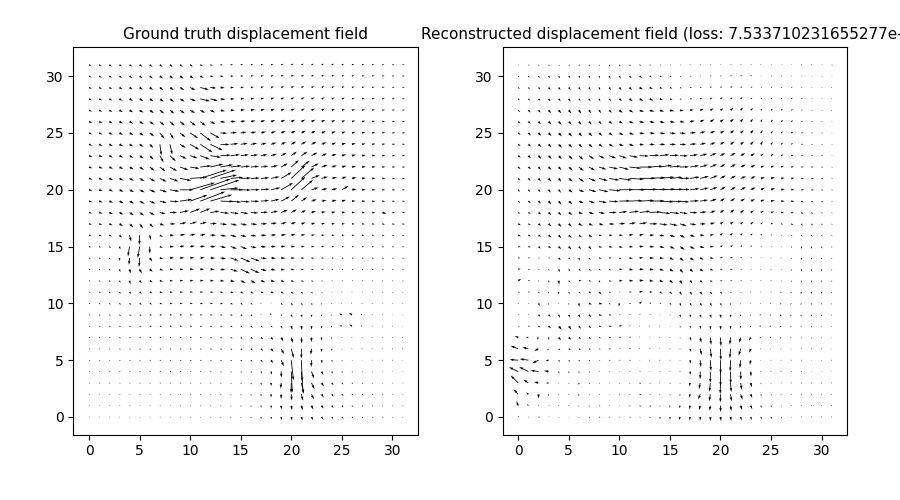

Text(0.5, 1.0, 'Reconstructed displacement field (loss: 7.533710231655277e-06)')

In [46]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(1,2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_val[0,0,:,:].detach().numpy(), X_val[0,1,:,:].detach().numpy(), scale=0.5)
axs[0].set_title('Ground truth displacement field', {'fontsize': 11})

axs[1].quiver(pred_autoenc[0,0,:,].detach().numpy(), pred_autoenc[0,1,:,:].detach().numpy(), scale=0.5)
axs[1].set_title(f'Reconstructed displacement field (loss: {pred_loss})', {'fontsize': 11})

Add noise.

In [47]:
cov = [[1e-3**2,0],[0,1e-3**2]]

In [48]:
X_noise = np.transpose(np.random.multivariate_normal(np.array([0,0]), cov,(len(X_val),32,32)), (0, 3, 2, 1))
X_noise = X_val + X_noise

In [49]:
noisy_pred_autoenc = autoenc(X_noise.float())

In [50]:
noisy_loss = loss(X_val[0,:,:,:], noisy_pred_autoenc[0,:,:,])

<IPython.core.display.Javascript object>


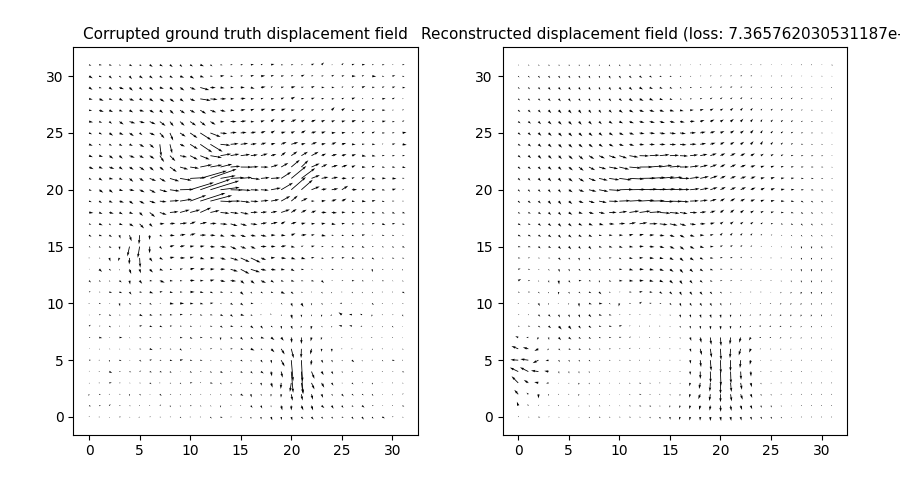

Text(0.5, 1.0, 'Reconstructed displacement field (loss: 7.365762030531187e-06)')

In [51]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(1,2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_noise[0,0,:,:].detach().numpy(), X_noise[0,1,:,:].detach().numpy(), scale=0.5)
axs[0].set_title('Corrupted ground truth displacement field', {'fontsize': 11})

axs[1].quiver(noisy_pred_autoenc[0,0,:,].detach().numpy(), noisy_pred_autoenc[0,1,:,:].detach().numpy(), scale=0.5)
axs[1].set_title(f'Reconstructed displacement field (loss: {noisy_loss})', {'fontsize': 11})

In [52]:
dspl_res_32_small = h5py.File('data/Test data/test_displacements_50.h5')["dspl"]
trac_res_32_small = h5py.File('data/Test data/test_displacements_50.h5')["trac"]

dspl_res_32 = h5py.File('data/extended data/resolution_32_32/allDisplacements_res_32')["dspl"]
trac_res_32 = h5py.File('data/extended data/resolution_32_32/allTractions_res_32')["trac"]

dspl_large = np.moveaxis(np.concatenate([dspl_res_32[i] for i in range(dspl_res_32.shape[0])], axis=0), 3, 1)
dspl_small = np.moveaxis(np.concatenate([dspl_res_32_small[i] for i in range(dspl_res_32_small.shape[0])], axis=0), 3, 1)
dspl = np.concatenate((dspl_large, dspl_small), axis=0)

trac_separated_large = np.moveaxis(np.concatenate([trac_res_32[i] for i in range(trac_res_32.shape[0])], axis=0), 3, 1)
trac_separated_small = np.moveaxis(np.concatenate([trac_res_32_small[i] for i in range(trac_res_32_small.shape[0])], axis=0), 3, 1)
trac_separated = np.concatenate((trac_separated_large, trac_separated_small), axis=0)

dspl_train = dspl[0:13000, :, :, :]
dspl_val = dspl[13000:, :, :, :]
trac_train = trac_separated[0:13000, :, :, :]
trac_val = trac_separated[13000:, :, :, :]

X_train = torch.from_numpy(dspl_train).float()
Y_train = torch.from_numpy(trac_train).float()
X_val = torch.from_numpy(dspl_val).float()
Y_val = torch.from_numpy(trac_val).float()

train_set = TensorDataset(X_train, X_train)
val_set = TensorDataset(X_val, X_val)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'data/Test data/test_displacements_50.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### [Gaussian process layers](https://arxiv.org/pdf/2106.00638.pdf)

__Goal__: Use variance of GP as distance measure between new input and already observed training data.

__Idea__: 
  1. Combination of Deep Neural Networks (DNNs) and Gaussian Processes (GPs)
  2. Scalable Variational Gaussian Processes (SVGPs): Complexity of O(m³) with m as number of inducing points
  3. Use the outputs of a neural network as the input to an uncertainty aware GP
  4. Given a new input sample, the GP model provides a predictive distribution over (univariate!) target variable

__Algorithm__: 
  1. Train backbone (e.g. CNN, Transformer) on some problem
  2. Generate inducing points by feeding images into the model and embed them
  3. Use these embedding points as inducing points for SVGP
  4. Maximize SVGP parameters (e.g. scaling parameter of RBF kernel) by maximizing ELBO

__Problem__: For every target variable, one SVGP has to be trained. Furthermore, SVGPs assume independence between the target variables.